In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


tf.random.set_seed(42)

In [17]:
data_dir = "IndicTTS/data"
languages = np.array(tf.io.gfile.listdir(data_dir))
print('Languages:', languages)

Languages: ['Telegu' 'Gujarati' 'Kannada' 'Tamil' 'Hindi' 'Malayalam']


In [56]:
train_ds_unbatched, val_ds_unbatched = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=None,
    validation_split = 0.2, 
    seed = 3,
    subset='both',
    shuffle = True
)

label_names = np.array(train_ds_unbatched.class_names)
print()
print("label names:", label_names)

Found 43070 files belonging to 6 classes.
Using 34456 files for training.
Using 8614 files for validation.

label names: ['Gujarati' 'Hindi' 'Kannada' 'Malayalam' 'Tamil' 'Telegu']


In [57]:
train_ds_unbatched.element_spec

(TensorSpec(shape=(None, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [58]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds_unbatched = train_ds_unbatched.map(squeeze, tf.data.AUTOTUNE)
val_ds_unbatched = val_ds_unbatched.map(squeeze, tf.data.AUTOTUNE)

In [59]:
train_ds_unbatched.element_spec

(TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [60]:
def trim(audio, labels):
    trimmed_audio = tf.signal.frame(audio, frame_length=int(5*16000), frame_step=int(4*16000), pad_end=True)
    trimmed_labels = tf.repeat(labels, tf.shape(trimmed_audio)[0])
    return trimmed_audio, trimmed_labels

train_ds_trimmed = train_ds_unbatched.map(trim, tf.data.AUTOTUNE)
val_ds_trimmed = val_ds_unbatched.map(trim, tf.data.AUTOTUNE)
train_ds_trimmed.element_spec

(TensorSpec(shape=(None, 80000), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [61]:
train_ds_trimmed.element_spec

(TensorSpec(shape=(None, 80000), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [62]:
train_ds = train_ds_trimmed.unbatch().shuffle(3).batch(64)
val_ds = val_ds_trimmed.unbatch().shuffle(3).batch(64)
train_ds.element_spec

(TensorSpec(shape=(None, 80000), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [63]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [26]:
mel_spectrogram = tf.keras.layers.MelSpectrogram(num_mel_bins = 64,
                                                 sampling_rate = 16000,
                                                 sequence_stride = 255,
                                                 fft_length = 511)

In [27]:
example_audios, example_labels = next(iter(train_ds))

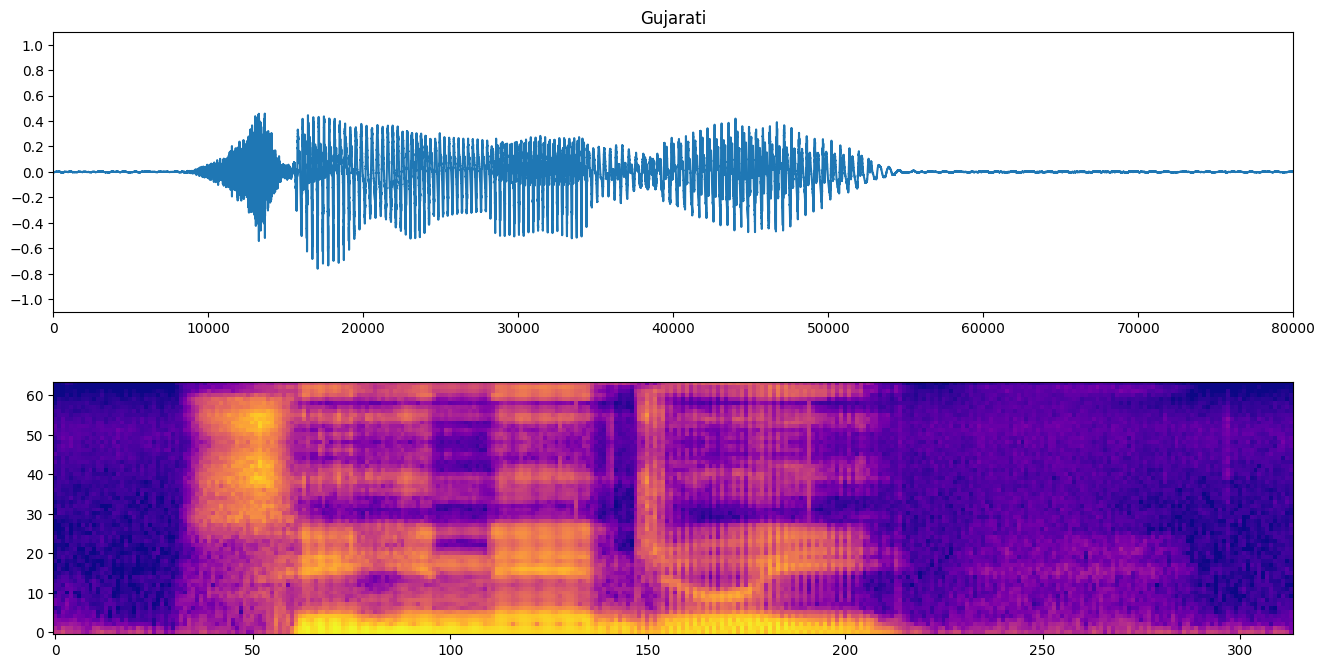

In [28]:
audio0, label0 = example_audios[2], example_labels[2]
plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
plt.plot(audio0)
plt.title(label_names[label0])
plt.yticks(np.arange(-1.2, 1.2, 0.2))
plt.ylim([-1.1, 1.1])
plt.xlim([0, 16000*5])
example_spectrogram = mel_spectrogram(audio0)
plt.subplot(2,1,2)
plt.imshow(tf.squeeze(example_spectrogram), cmap='plasma', origin="lower")


In [29]:
model_0 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(5*16000,)),
    mel_spectrogram,
    tf.keras.layers.Lambda(lambda x:tf.expand_dims(x, axis=-1)),
    tf.keras.layers.Resizing(32,32),
    tf.keras.layers.Conv2D(32,3,activation="relu"),
    tf.keras.layers.Conv2D(64,3,activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation="softmax")
])

model_0.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mel_spectrogram_1               │ (None, 64, 314)        │             0 │
│ (MelSpectrogram)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 64, 314, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_1 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,350 (6.20 MB)

 Trainable params: 1,625,350 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model_0.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

model_0.fit(train_ds,
            validation_data=val_ds,
            epochs = 10,
            steps_per_epoch = 100,
            validation_steps = 30)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 0.2568 - loss: 8.0728 - val_accuracy: 0.7260 - val_loss: 0.8398
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 0.6339 - loss: 0.9511 - val_accuracy: 0.7432 - val_loss: 0.6920
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 157ms/step - accuracy: 0.7540 - loss: 0.6478 - val_accuracy: 0.8255 - val_loss: 0.4939
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step - accuracy: 0.8085 - loss: 0.5237 - val_accuracy: 0.8625 - val_loss: 0.3871
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 0.8303 - loss: 0.4757 - val_accuracy: 0.9052 - val_loss: 0.3010
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 0.8702 - loss: 0.3593 - val_accuracy: 0.9312 - val_loss: 0.2091
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 0.8722 - loss: 0.3536 - val_accuracy: 0.9234 - val_loss: 0.2123
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 0.8779 - loss: 0

In [31]:
model_0.evaluate(test_ds, steps=100)

100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.9354 - loss: 0.1798


[0.17648887634277344, 0.9387500286102295]

In [66]:
import os
import random

x = "IndicTTS/data/Tamil/"
x = x+random.choice(os.listdir(x))
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000*5,)
x = tf.squeeze(x, axis=-1)
x = x[tf.newaxis,...]

prediction = model_0.predict(x)
label_names[np.argmax(prediction)]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


'Tamil'

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step


2024-04-06 09:39:54.943551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-04-06 09:39:55.755012: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


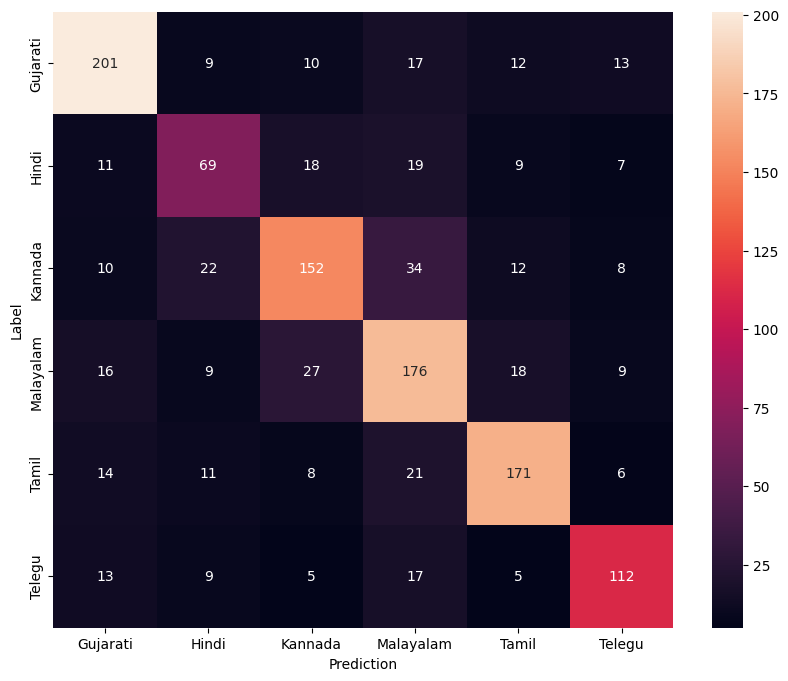

In [65]:
import seaborn as sns

test_data = test_ds.take(20)
model_0_pred = model_0.predict(test_data)
model_0_pred= tf.argmax(model_0_pred, axis=1)
model_0_pred
actual_labels = tf.concat(list(test_data.map(lambda audio,label: label)), axis=0)

confusion_mtx = tf.math.confusion_matrix(actual_labels, model_0_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

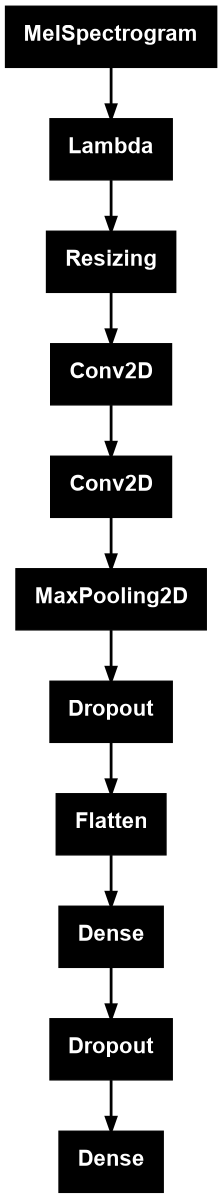

In [34]:
from tensorflow.keras.utils import plot_model
plot_model(model_0,dpi=100)